<a href="https://colab.research.google.com/github/aditya27you/INTENSHIP-TASK-BY-CT/blob/main/task2_2_ml_movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install pyspark


In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


In [9]:
# Start Spark Session
spark = SparkSession.builder \
    .appName("BigDataMoviesML") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [10]:
df = spark.read.csv("/content/title.basics.tsv", header=True, inferSchema=True, sep="\t")
df.printSchema()
df.show(5)

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation

In [11]:
# Display summary statistics for numerical columns
df.describe().show()

# Check for missing values
from pyspark.sql.functions import col, sum as spark_sum
df.select(*(spark_sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns)).show()

# Display distinct values for categorical columns (e.g., titleType, isAdult)
df.select('titleType').distinct().show()
df.select('isAdult').distinct().show()
df.select('genres').distinct().show(truncate=False) # Show all genres without truncation

+-------+---------+---------+------------------+------------------+--------------------+------------------+------------------+-----------------+------+
|summary|   tconst|titleType|      primaryTitle|     originalTitle|             isAdult|         startYear|           endYear|   runtimeMinutes|genres|
+-------+---------+---------+------------------+------------------+--------------------+------------------+------------------+-----------------+------+
|  count|    78845|    78845|             78845|             78845|               78845|             78845|             78845|            78845| 78845|
|   mean|     NULL|     NULL|1273.6192631578947|1138.1714444444444|0.003424440357663...| 1946.693339928719|1969.4421626152557|74.16307448028464|  NULL|
| stddev|     NULL|     NULL| 853.7799633761904| 897.4665264968824| 0.05841880562181526|21.075563844171747|10.610593939493716|39.16034179528157|  NULL|
|    min|tt0000001|    movie|                 $|                 $|                   0|

## Handle missing values

### Subtask:
Address the missing values in the 'genres' column.


**Reasoning**:
Fill the missing values in the 'genres' column with 'Unknown' and then check for nulls in that column to verify.



In [12]:
df = df.fillna({'genres': 'Unknown'})
df.select(spark_sum(col('genres').isNull().cast("integer")).alias('genres')).show()

+------+
|genres|
+------+
|     0|
+------+



## Clean and convert data types

### Subtask:
Clean and convert 'startYear', 'endYear', and 'runtimeMinutes' to appropriate numeric types, handling the '\N' values. Also, examine and potentially clean the 'isAdult' column.


In [13]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when, col, lit

# Replace '\N' with None and cast to IntegerType for startYear and endYear
df = df.withColumn("startYear", when(col("startYear") == "\\N", None).otherwise(col("startYear").cast(IntegerType())))
df = df.withColumn("endYear", when(col("endYear") == "\\N", None).otherwise(col("endYear").cast(IntegerType())))

# Replace '\N' with None and cast to IntegerType for runtimeMinutes
df = df.withColumn("runtimeMinutes", when(col("runtimeMinutes") == "\\N", None).otherwise(col("runtimeMinutes").cast(IntegerType())))

# Examine distinct values in isAdult again
df.select('isAdult').distinct().show()

# Based on the previous distinct values output (0, 1, 2019, 2020, 1981, 2017), filter out the unexpected values
df = df.filter(col("isAdult").isin([0, 1]))

# Verify the schema and distinct values after cleaning
df.printSchema()
df.select('isAdult').distinct().show()
df.select(*(spark_sum(col(c).isNull().cast("integer")).alias(c) for c in ['startYear', 'endYear', 'runtimeMinutes', 'isAdult'])).show()

+-------+
|isAdult|
+-------+
|      1|
|      0|
+-------+

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = false)

+-------+
|isAdult|
+-------+
|      1|
|      0|
+-------+

+---------+-------+--------------+-------+
|startYear|endYear|runtimeMinutes|isAdult|
+---------+-------+--------------+-------+
|        2|  76459|         10827|      0|
+---------+-------+--------------+-------+



## Feature engineering

### Subtask:
Based on the analysis goals, consider creating new features from existing columns (e.g., extracting primary genre, calculating movie age).


In [14]:
from pyspark.sql.functions import split, element_at, lit
import datetime

# Define 'primaryGenre'
df = df.withColumn('primaryGenre', element_at(split(col('genres'), ','), 1))

# Define 'movieAge'
current_year_val = datetime.datetime.now().year
df = df.withColumn('movieAge', lit(current_year_val) - col('startYear'))

# Show schema and first few rows
df.printSchema()
df.show(5)

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = false)
 |-- primaryGenre: string (nullable = true)
 |-- movieAge: integer (nullable = true)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|primaryGenre|movieAge|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+------------+--------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|   NULL|

## Handle missing values

### Subtask:
Address the missing values in the 'genres' column.

In [15]:
from pyspark.sql.functions import col, sum as spark_sum

df = df.fillna({'genres': 'Unknown'})
df.select(spark_sum(col('genres').isNull().cast("integer")).alias('genres')).show()

+------+
|genres|
+------+
|     0|
+------+



In [16]:
from pyspark.sql.functions import split, element_at, lit

# Define 'primaryGenre'
df = df.withColumn('primaryGenre', element_at(split(col('genres'), ','), 1))

# Define 'movieAge' using a literal for the current year
current_year_val = 2025
df = df.withColumn('movieAge', lit(current_year_val) - col('startYear'))

# Show schema and first few rows
df.printSchema()
df.show(5)

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = false)
 |-- primaryGenre: string (nullable = true)
 |-- movieAge: integer (nullable = true)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|primaryGenre|movieAge|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+------------+--------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|   NULL|

## Prepare Data for ML

### Subtask:
Convert categorical features into numerical format using StringIndexer and assemble all features into a single vector column using VectorAssembler.

In [17]:
df = spark.read.csv("/content/title.basics.tsv",
                    sep="\t",    # <-- important for TSV
                    header=True,
                    inferSchema=True)

Schema before StringIndexer fit:
root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = false)
 |-- primaryGenre: string (nullable = true)
 |-- movieAge: integer (nullable = true)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,1894.0,131.0...|    1|
|[0.0,1892.0,133.0...|    5|
|[0.0,1892.0,133.0...|    5|
|[0.0,1892.0,133.0...|   12|
|[0.0,1893.0,132.0...|    1|
+--------------------+-----+
only showing top 5 rows

+-----+------------------+
|label|        prediction|
+-----+------------------+
|    5|10.055578995548982|
|    1|  18.6194333625473|
|    1|17.937927553125867|
|    1|  18.6194333625473|
|    1|  18.6194333625473

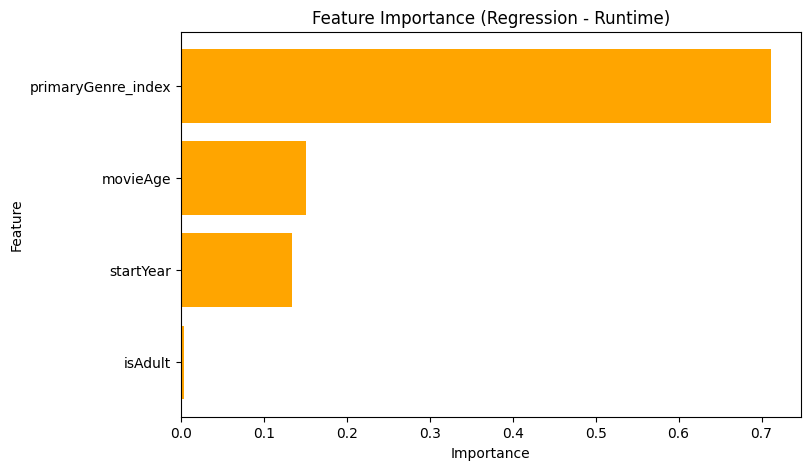

In [18]:
# Build Machine Learning Models (Regression)
# Dataset: Movies Dataset

# Import Libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator # Corrected typo here
from pyspark.sql.functions import col, when, split, element_at, lit
from pyspark.sql.types import IntegerType
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Start Spark Session (if not already started)
spark = SparkSession.builder.appName("BigDataMoviesML_Regression").getOrCreate()

# Load Dataset
df = spark.read.csv("/content/title.basics.tsv", header=True, inferSchema=True, sep="\t")

# Data Cleaning: Handle '\N' values and convert data types
df = df.withColumn("startYear", when(col("startYear") == "\\N", None).otherwise(col("startYear").cast(IntegerType())))
df = df.withColumn("endYear", when(col("endYear") == "\\N", None).otherwise(col("endYear").cast(IntegerType())))
df = df.withColumn("runtimeMinutes", when(col("runtimeMinutes") == "\\N", None).otherwise(col("runtimeMinutes").cast(IntegerType())))
df = df.filter(col("isAdult").isin([0, 1])) # Filter out unexpected isAdult values
df = df.fillna({'genres': 'Unknown'}) # Handle missing genres

# Feature Engineering: Create 'primaryGenre' and 'movieAge'
df = df.withColumn('primaryGenre', element_at(split(col('genres'), ','), 1))
current_year_val = datetime.datetime.now().year # Use current year for movieAge
df = df.withColumn('movieAge', lit(current_year_val) - col('startYear'))

# Data Preparation for ML

# Print schema before StringIndexer fit to check for primaryGenre
print("Schema before StringIndexer fit:")
df.printSchema()

# Convert 'primaryGenre' to numerical using StringIndexer
genre_indexer = StringIndexer(inputCol="primaryGenre", outputCol="primaryGenre_index").fit(df)
df_indexed = genre_indexer.transform(df)

# Handle missing values in runtimeMinutes and startYear by filtering *after* indexing
df_reg = df_indexed.filter(col("runtimeMinutes").isNotNull() & col("startYear").isNotNull() & col("movieAge").isNotNull() & col("primaryGenre_index").isNotNull())


# Define feature columns for regression
feature_cols_reg = ["isAdult", "startYear", "movieAge", "primaryGenre_index"]

# Assemble features into a single vector
assembler_reg = VectorAssembler(inputCols=feature_cols_reg, outputCol="features")
df_reg = assembler_reg.transform(df_reg)

# Scale features (optional but often beneficial for ML models)
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
# scaler_model = scaler.fit(df_reg)
# df_reg = scaler_model.transform(df_reg)

# Final dataset for regression
# Use 'runtimeMinutes' as the label and the assembled/scaled features
reg_data = df_reg.select("features", col("runtimeMinutes").alias("label"))
# If using scaled features:
# reg_data = df_reg.select("scaledFeatures", col("runtimeMinutes").alias("label"))

reg_data.show(5)


# Train/Test Split
train_reg, test_reg = reg_data.randomSplit([0.8, 0.2], seed=42)

# Build Random Forest Regressor
rf_reg = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100, maxDepth=10, seed=42)
rf_reg_model = rf_reg.fit(train_reg)

# Predictions
pred_reg = rf_reg_model.transform(test_reg)
pred_reg.select("label", "prediction").show(10)

# Evaluation (Regression)
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(pred_reg)
r2 = evaluator_r2.evaluate(pred_reg)

print(" Regression Model Performance:")
print(f" RMSE: {rmse:.2f}")
print(f" R² Score: {r2:.4f}")

# Feature Importance
# Note: Feature importance from VectorAssembler requires matching indices to original feature names
# This is a simplified way to get importance based on the order in feature_cols_reg
fi_reg = rf_reg_model.featureImportances.toArray()
fi_reg_pd = pd.DataFrame(list(zip(feature_cols_reg, fi_reg)), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

print(" Regression Feature Importance:")
print(fi_reg_pd)

# Plot
plt.figure(figsize=(8,5))
plt.barh(fi_reg_pd["Feature"], fi_reg_pd["Importance"], color="orange")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Regression - Runtime)")
plt.gca().invert_yaxis()
plt.show()
